In [1]:
import csv
import numpy as np
import gensim
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile,datapath
from gensim.models.word2vec import LineSentence
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
#词向量特征
#词向量训练的回调函数，用来打印loss、保存模型等等（注意，即使不训练词向量，加载时也要载入这个类）
class train_log_word(gensim.models.callbacks.CallbackAny2Vec):
    def __init__(self, savename):
        self.loss = []
        self.time = 0.0
        self.epoch = 0
        self.savename = savename
    #在每一轮开始的时候
    def on_epoch_begin(self,model):
        self.time = time.time()
    #在每一轮结束的时候
    def on_epoch_end(self,model):
        self.epoch+=1
        print('Epoch '+str(self.epoch)+' using time '+str(time.time()-self.time)+' seconds')
        #这个loss似乎是总的loss叠加
        print('loss: '+str(model.get_latest_training_loss()))
        self.loss.append(model.get_latest_training_loss())
        #5轮保存一次
        if(self.epoch%5==0):
            model.save(self.savename)
            print("Model %s save done!" % self.savename)
        #50轮作图一次
        if(self.epoch%50==0):
            plt.plot(np.array(self.loss))
            plt.title('Model loss')
            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            #plt.legend(['Train', 'Test'], loc='upper left')
            plt.show()
            
            
#训练词向量,参数说明：存放corpus的文件，输出的文件名，轮数，词向量维数，中心词最远处理距离，线程数，过滤低于min_count的词，
#sg=1为skip_gram训练方式、否则为cbow训练方式. alpha为初始学习率，min_alpha为最终学习率，学习率会逐渐降低至最终学习率.
def make_w2v_model(corfile,output_model,
                       epochs=100,vec_size=300,window=5,workers = 16,min_count=0,sg=1,alpha=0.025, min_alpha=0.0001):
    start_time=time.time()
    #读取语料文件为gensim需要的输入，行流式读取
    cor=LineSentence(corfile)
    #模型构建
    model = gensim.models.Word2Vec(size=vec_size,window=window, workers=workers,sg=sg,min_count=min_count, 
                                   alpha = alpha,min_alpha = min_alpha)
    #建立字典
    model.build_vocab(cor)
    #训练模型,注意这里使用了回调模型——train_log
    model.train(cor,total_words=model.corpus_total_words,epochs=epochs,callbacks=[train_log_word(output_model)],compute_loss = True)
    print("word2vec training complete,epochs:"+str(epochs)+" using time:"+str(time.time()-start_time)+' seconds')
    return model



In [3]:

# 将字典保存为本地文件
def save_dict(save_dict,save_file):
    with open(save_file,'w') as sv:
        start = time.time()
        sv.write(str(save_dict))
        print('save dict using time'+str(time.time()-start))
        
#从本地文件加载字典
def load_dict(dict_file):
    with open(dict_file,'r') as df:
        return eval(df.read())
    
#语料中生成字典，从1开始增序编号，如果词向量模型中没有该词则索引为0
def make_dict(w2vmodel,cor_file,cor_length,start=0):
    with open(cor_file) as cf:
        all_words={}
        cnt=1
        for i in tqdm(range(cor_length),mininterval=1.0):
            if i<start:
                continue
            for word in cf.readline().replace('\n','').split(' '):
                try:
                    w2vmodel.wv[word]
                    if word not in all_words:
                        all_words[word]=cnt
                        cnt+=1 
                except:
                    all_words[word]=0
        return all_words

# 根据字典中编号顺序保存词向量为txt文件
def savew2v_byindex(w2vmodel,my_dict,savefile):
    with open(savefile,'w') as sf:
        sf.write('{0}\n'.format(str(np.zeros(300).tolist())))
        for key in tqdm(my_dict,mininterval=1.0):
            sf.write('{0}\n'.format(str(w2vmodel.wv[key].tolist())))
            
#从本地词向量txt读取为nparray
def loadw2v_to_nparray(w2vfile,length):
    with open(w2vfile) as wf:
        w2varr = np.zeros(shape=(length,300),dtype=float)
        line_count=0
        for row in tqdm(range(length),mininterval=1.0):
            #print(wf.readline())
            #print(wf.readline())
            w2varr[row] = np.array(list(map(float,wf.readline()[1:-2].split(','))))
        return w2varr
    

#将train.csv中query和title分别处理输出：将词转换为索引
def coupus_csv2nparr(trainfile,dic,end,start=0):
    with open(trainfile,'r') as train_file:
        t_reader = csv.reader(train_file,delimiter=',')
        line_count=0
        query_cor=[]
        title_cor=[]
        lb=[]
        for row in tqdm(t_reader,mininterval=1.0):
            if line_count<start:
                line_count+=1
                continue
            if line_count>=end:
                break
            query=[]
            for word in row[1]:
                if word in dic:
                    query.append(dic[word])
                else:
                    query.append(0)
            query_cor.append(query)
            title=[]
            for word in row[3]:
                if word in dic:
                    title.append(dic[word])
                else:
                    title.append(0)
            title_cor.append(title)
            lb.append(int(row[4]))
        return np.array(query_cor),np.array(title_cor),np.array(lb)
    
#从本地手工特征文件读取为nparray 
def exfeature_to_arr(feature_file,end,start=0):
    with open(feature_file,'r') as ff:
        ft_reader = csv.reader(ff,delimiter=' ')
        ft = []
        line_count=0
        #for i in tqdm(range(end-start),mininterval=1.0):
        for i in tqdm(ft_reader,mininterval=1.0):
            if line_count<start:
                line_count+=1
                continue
            if line_count>=end:
                break
            #ft.append(list(map(float,ff.readline().split(','))))
            ft.append(i[0].split(','))
            line_count+=1
        result = np.array(ft,dtype=float)
        print(result.shape)
        return result

In [4]:
my_w2v = Word2Vec.load('word2vec.model')

In [5]:
my_dict = make_dict(my_w2v,'query_title.txt',20000)
dict_len = len(my_dict)
print(dict_len)
save_dict(my_dict,'cor_dict.txt')

100%|█████████████████████████████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 42394.01it/s]


36202
save dict using time0.006981372833251953


In [6]:
my_dict = load_dict('cor_dict.txt')
dict_len = len(my_dict)
#print(my_dict)

In [7]:
savew2v_byindex(my_w2v,my_dict,'index_w2v.txt')

100%|██████████████████████████████████████████████████████████████████████████| 36202/36202 [00:10<00:00, 3480.56it/s]


In [8]:
from tqdm import tqdm
w2v = loadw2v_to_nparray('index_w2v.txt',36202+1)

100%|██████████████████████████████████████████████████████████████████████████| 36203/36203 [00:07<00:00, 4933.38it/s]


In [9]:
print(w2v[1])

[ 6.51039243e-01 -3.58301282e-01 -1.25864401e-01  4.49612811e-02
  9.82721567e-01 -4.56663698e-01  9.78114426e-01  8.82056475e-01
  1.03397000e+00  2.25600198e-01 -1.39869899e-01 -4.90043014e-02
  4.50973421e-01  6.03350811e-02  3.40391725e-01 -5.11655688e-01
 -3.38430703e-01 -5.39314687e-01 -7.88030148e-01  1.33609146e-01
  9.64863598e-02 -1.68398581e-02  1.19910175e-02 -3.11141044e-01
 -4.60752547e-01  8.24275851e-01 -4.70046100e-04 -8.39701444e-02
  1.62124932e-01  1.71068668e-01 -3.62478614e-01  7.34649837e-01
  1.92381173e-01 -4.25238907e-01  5.43070793e-01  8.13569352e-02
  3.32031190e-01  5.46799481e-01 -3.25215876e-01  1.43086031e-01
 -1.87799975e-01  6.38559222e-01 -1.93173081e-01  5.74566841e-01
  1.20503545e+00 -3.59515101e-01 -6.80328190e-01 -5.89661717e-01
 -9.38028514e-01 -2.05821127e-01  3.64566267e-01  2.91239042e-02
  4.34218019e-01  5.02783060e-03 -2.68455185e-02  3.79263401e-01
 -4.42996770e-01 -5.75489104e-01 -9.53654706e-01 -1.05617829e-01
  2.27169201e-01 -2.10430

In [10]:
train_query,train_title,label=coupus_csv2nparr('train.csv',my_dict,20000)

20000it [00:00, 72134.75it/s]


In [11]:
train_query.shape

(20000,)

In [12]:
exft = exfeature_to_arr('all_feature.txt',20000)

20000it [00:00, 70602.56it/s]


(20000, 40)


In [13]:
print(exft[0])

[ 3.80000000e+01  1.80000000e+01  2.11111111e+00  1.00000000e+00
  1.20877854e+00  9.33196312e-01  5.60425649e-02  2.07726177e-01
  9.94388091e+01  6.66894878e-02  1.00000000e+00  1.00000000e+00
  1.46114556e+00  1.40855911e-01  2.66456507e-01  2.78545207e-02
  2.38183446e-03  6.33851601e+00  1.23598145e-01  3.37712130e-01
  3.08814360e-01  1.00000000e+00  2.51708193e-01  2.95747185e-01
  6.37731062e-02  3.30965245e-03  3.77562289e+00  2.67254779e-01
  3.04215459e+00  6.49082565e-02  2.33642355e-02  9.92626359e-01
  2.64556017e+02  9.37506179e-01  1.00000000e+00  1.00000000e+00
  9.25470452e+00  5.94897967e-01 -1.28274008e+00  9.33920912e-01]


In [14]:
label[0]

1

In [15]:
import tensorflow as tf
import keras 
from keras import layers
from keras.models import Model
from keras.layers import Input,Dense,Embedding,GRU,Lambda,Dropout,Concatenate,Subtract
from keras.utils import plot_model
from scipy.spatial import distance

Using TensorFlow backend.


In [16]:
train_query = keras.preprocessing.sequence.pad_sequences(train_query,30)
train_title = keras.preprocessing.sequence.pad_sequences(train_title,30)

In [17]:
from sklearn.metrics import roc_auc_score

class train_log(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.aucs = []
        self.losses = []
        self.val_losses=[]
    def on_epoch_end(self, epoch, logs={}):
        #每轮训练结束后，计算auc
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        y_pred = self.model.predict([self.validation_data[0],self.validation_data[1]])
        yp = []
        for i in range(len(y_pred)):
            yp.append(y_pred[i][0])
        yt = []
        for x in self.validation_data[2]:
            yt.append(x[0])
        auc = roc_auc_score(yt, yp)
        self.aucs.append(auc)
        print (' val-auc: ',auc)



In [18]:
from keras import backend as K
#曼哈顿距离
def exponent_neg_manhattan_distance(left, right):
    return K.exp(-K.sum(K.abs(left - right), axis=1, keepdims=True))
#欧氏距离
def eudi_dis(left, right):
    return K.sqrt(K.sum(K.square(left - right), axis=1, keepdims=True))

####简单的双输入
def multiinput_gru_model(vocab_length):
    #双输入层，分别输入query与title
    #需要分别padding所有句子至相同长度
    input1 = Input(shape=(30,),dtype='int32',name='query_input')
    input2 = Input(shape=(30,),dtype='int32',name='title_input')
    #嵌入层，将输入词索引与词向量关联
    embedding1 = Embedding(input_dim=vocab_length+1,
                           output_dim=300,
                           #input_length=500,
                           weights=[w2v],
                           mask_zero=True,
                           trainable=False,
                           name='query_embedding')(input1)
    embedding2 = Embedding(input_dim=vocab_length+1,
                           output_dim=300,
                           #input_length=115,
                           weights=[w2v],
                           mask_zero=True,
                           trainable=False,
                           name='title_embedding')(input2)
    #伪孪生（不共享权重）gru循环层
    gru1= GRU(units=30,
               #return_sequences=True,
               #recurrent_dropout=0.1,
              #dropout=0.5,
               unroll=True,
                name='query_gru')(embedding1)
    gru2= GRU(units=30,
               #return_sequences=True,
               #recurrent_dropout=0.1,
              #dropout=0.5,
               unroll=True,
                name='title_gru')(embedding2)
    ########################
    #输出句向量计算相似度层
    mah_distance = Lambda(lambda x: exponent_neg_manhattan_distance(x[0], x[1]),
                                output_shape=lambda x: (x[0][0], 1),name='gru_output_to_mahdis')([gru1, gru2])
    eudi_distance = Lambda(lambda x: eudi_dis(x[0], x[1]),
                               output_shape=lambda x: (x[0][0], 1),name='gru_output_to_eudidis')([gru1, gru2])
    #句向量做差得关系向量，加快模型学习
    minor_t = Subtract(name='gru_output_subtract')([gru1,gru2])
    ###############
    #额外特征输入
    input3 = Input(shape=(20,),name='extra_feature_input')
    #j将额外输入，gru输出，以及相似度，关系向量输出合并
    concat_all = keras.layers.Concatenate(axis=-1,name='concatenate_to_dense')([gru1,gru2,mah_distance,eudi_distance,minor_t])
    #合并层连接全连接层
    dense1 = Dense(units=2048,
                                activation='relu',
                                input_shape=(902,),name='dense1')(concat_all)
    dense1_5 = Dense(units=1024,
                                activation='relu',name='dense2')(dense1)
    dense1_6 = Dense(units=1024,
                                activation='relu',name='dense3')(dense1_5)
    dense2 = Dense(units=1024,
                                activation='relu',name='dense4')(dense1_6)
    dense3 = Dense(units=512,
                                activation='relu',name='dense5')(dense2)
    dense3_5 = Dense(units=512,
                                activation='relu',name='dense6')(dense3)
    dense4 = Dense(units=512,
                                activation='relu',name='dense7')(dense3_5)
    dense5 = Dense(units=256,
                                activation='relu',name='dense8')(dense4)
    dense5_5 = Dense(units=256,
                                activation='relu',name='dense9')(dense5)
    dense6 = Dense(units=256,
                                activation='relu',name='dense10')(dense5)
    dense7 = Dense(units=128,
                                activation='relu',name='dense11')(dense6)
    dense7_5 = Dense(units=128,
                                activation='relu',name='dense12')(dense7)
    dense8 = Dense(units=64,
                                activation='relu',name='dense13')(dense7_5)
    dense9 = Dense(units=64,
                                activation='relu',name='dense14')(dense8)
    dense10 = Dense(units=32,
                                activation='relu',name='dense15')(dense9)
    
    #单输出，0-1
    output = Dense(units=1,
                                activation='sigmoid',name='output')(dense10)
    #####
    model = Model(inputs=[input1,input2],outputs=[output])
    model.summary()
    model.compile(optimizer='adam',loss='binary_crossentropy')
    return model

In [19]:
gru_model = multiinput_gru_model(vocab_length=dict_len)

W0704 10:47:19.945273 13656 deprecation_wrapper.py:119] From d:\gongjubao\miniconda3_4.54\envs\huaweilab\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0704 10:47:19.980178 13656 deprecation_wrapper.py:119] From d:\gongjubao\miniconda3_4.54\envs\huaweilab\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0704 10:47:19.991151 13656 deprecation_wrapper.py:119] From d:\gongjubao\miniconda3_4.54\envs\huaweilab\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0704 10:47:19.992149 13656 deprecation_wrapper.py:119] From d:\gongjubao\miniconda3_4.54\envs\huaweilab\lib\site-packages\keras\backend\tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto i

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
query_input (InputLayer)        (None, 30)           0                                            
__________________________________________________________________________________________________
title_input (InputLayer)        (None, 30)           0                                            
__________________________________________________________________________________________________
query_embedding (Embedding)     (None, 30, 300)      10860900    query_input[0][0]                
__________________________________________________________________________________________________
title_embedding (Embedding)     (None, 30, 300)      10860900    title_input[0][0]                
__________________________________________________________________________________________________
query_gru 

W0704 10:47:22.272053 13656 deprecation_wrapper.py:119] From d:\gongjubao\miniconda3_4.54\envs\huaweilab\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [20]:
import time
start=time.time()
my_log = train_log()
gru_his = gru_model.fit(x=[train_query[:18000],train_title[:18000]],
                   y=[label[:18000]],
                   epochs=2,
                   validation_split=0.1,
                        batch_size=16,
                     callbacks=[#keras.callbacks.EarlyStopping(monitor='val_loss',patience=3, verbose=2, mode='min'),
                               keras.callbacks.TerminateOnNaN(),
                                 my_log
                                #keras.callbacks.ModelCheckpoint('model/sia-gru.model', monitor='val_loss', verbose=1, save_best_only=True,mode='auto')
                             ])
#callbacks=[Histories(),keras.callbacks.ModelCheckpoint(filepath='model/gru_multiinput.model', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)]
print('using time'+str(time.time()-start))

Train on 16200 samples, validate on 1800 samples
Epoch 1/2


 4976/16200 [========>.....................] - ETA: 1:54:12 - loss: 0.69 - ETA: 57:39 - loss: 0.6900 - ETA: 38:49 - loss: 0.67 - ETA: 29:23 - loss: 0.62 - ETA: 23:44 - loss: 0.61 - ETA: 19:57 - loss: 0.62 - ETA: 17:16 - loss: 0.61 - ETA: 15:14 - loss: 0.61 - ETA: 13:40 - loss: 0.62 - ETA: 12:24 - loss: 0.62 - ETA: 11:23 - loss: 0.62 - ETA: 10:31 - loss: 0.61 - ETA: 9:48 - loss: 0.6245 - ETA: 9:11 - loss: 0.612 - ETA: 8:38 - loss: 0.604 - ETA: 8:10 - loss: 0.608 - ETA: 7:45 - loss: 0.600 - ETA: 7:23 - loss: 0.596 - ETA: 7:03 - loss: 0.588 - ETA: 6:45 - loss: 0.596 - ETA: 6:29 - loss: 0.594 - ETA: 6:14 - loss: 0.589 - ETA: 6:00 - loss: 0.595 - ETA: 5:48 - loss: 0.597 - ETA: 5:37 - loss: 0.596 - ETA: 5:27 - loss: 0.593 - ETA: 5:17 - loss: 0.594 - ETA: 5:09 - loss: 0.596 - ETA: 5:00 - loss: 0.592 - ETA: 4:52 - loss: 0.595 - ETA: 4:45 - loss: 0.590 - ETA: 4:39 - loss: 0.594 - ETA: 4:32 - loss: 0.600 - ETA: 4:26 - loss: 0.600 - ETA: 4:21 - loss: 0.599 - ETA: 4:16 - loss: 0.599 - ETA: 4:11 - 

10288/16200 [==================>...........] - ETA: 1:13 - loss: 0.576 - ETA: 1:13 - loss: 0.575 - ETA: 1:13 - loss: 0.576 - ETA: 1:13 - loss: 0.576 - ETA: 1:13 - loss: 0.575 - ETA: 1:12 - loss: 0.575 - ETA: 1:12 - loss: 0.575 - ETA: 1:12 - loss: 0.575 - ETA: 1:12 - loss: 0.575 - ETA: 1:12 - loss: 0.574 - ETA: 1:12 - loss: 0.574 - ETA: 1:11 - loss: 0.574 - ETA: 1:11 - loss: 0.575 - ETA: 1:11 - loss: 0.575 - ETA: 1:11 - loss: 0.575 - ETA: 1:11 - loss: 0.575 - ETA: 1:11 - loss: 0.575 - ETA: 1:11 - loss: 0.575 - ETA: 1:10 - loss: 0.575 - ETA: 1:10 - loss: 0.575 - ETA: 1:10 - loss: 0.575 - ETA: 1:10 - loss: 0.575 - ETA: 1:10 - loss: 0.575 - ETA: 1:10 - loss: 0.575 - ETA: 1:10 - loss: 0.575 - ETA: 1:09 - loss: 0.575 - ETA: 1:09 - loss: 0.576 - ETA: 1:09 - loss: 0.577 - ETA: 1:09 - loss: 0.577 - ETA: 1:09 - loss: 0.577 - ETA: 1:09 - loss: 0.577 - ETA: 1:09 - loss: 0.577 - ETA: 1:08 - loss: 0.577 - ETA: 1:08 - loss: 0.577 - ETA: 1:08 - loss: 0.577 - ETA: 1:08 - loss: 0.577 - ETA: 1:08 - loss:

15728/16200 [============================>.] - ETA: 34s - loss: 0.57 - ETA: 34s - loss: 0.57 - ETA: 34s - loss: 0.57 - ETA: 34s - loss: 0.57 - ETA: 34s - loss: 0.57 - ETA: 34s - loss: 0.57 - ETA: 33s - loss: 0.57 - ETA: 33s - loss: 0.57 - ETA: 33s - loss: 0.57 - ETA: 33s - loss: 0.57 - ETA: 33s - loss: 0.57 - ETA: 33s - loss: 0.57 - ETA: 33s - loss: 0.57 - ETA: 33s - loss: 0.57 - ETA: 33s - loss: 0.57 - ETA: 33s - loss: 0.57 - ETA: 32s - loss: 0.57 - ETA: 32s - loss: 0.57 - ETA: 32s - loss: 0.57 - ETA: 32s - loss: 0.57 - ETA: 32s - loss: 0.57 - ETA: 32s - loss: 0.57 - ETA: 32s - loss: 0.57 - ETA: 32s - loss: 0.57 - ETA: 32s - loss: 0.57 - ETA: 32s - loss: 0.57 - ETA: 31s - loss: 0.57 - ETA: 31s - loss: 0.57 - ETA: 31s - loss: 0.57 - ETA: 31s - loss: 0.57 - ETA: 31s - loss: 0.57 - ETA: 31s - loss: 0.57 - ETA: 31s - loss: 0.57 - ETA: 31s - loss: 0.57 - ETA: 31s - loss: 0.57 - ETA: 31s - loss: 0.57 - ETA: 30s - loss: 0.57 - ETA: 30s - loss: 0.57 - ETA: 30s - loss: 0.57 - ETA: 30s - loss: 

16200/16200 [==============================] - ETA: 2s - loss: 0.570 - ETA: 2s - loss: 0.571 - ETA: 2s - loss: 0.571 - ETA: 2s - loss: 0.571 - ETA: 2s - loss: 0.571 - ETA: 2s - loss: 0.571 - ETA: 2s - loss: 0.571 - ETA: 1s - loss: 0.571 - ETA: 1s - loss: 0.571 - ETA: 1s - loss: 0.571 - ETA: 1s - loss: 0.571 - ETA: 1s - loss: 0.570 - ETA: 1s - loss: 0.570 - ETA: 1s - loss: 0.570 - ETA: 1s - loss: 0.570 - ETA: 1s - loss: 0.571 - ETA: 1s - loss: 0.570 - ETA: 1s - loss: 0.570 - ETA: 0s - loss: 0.570 - ETA: 0s - loss: 0.570 - ETA: 0s - loss: 0.570 - ETA: 0s - loss: 0.570 - ETA: 0s - loss: 0.570 - ETA: 0s - loss: 0.570 - ETA: 0s - loss: 0.570 - ETA: 0s - loss: 0.570 - ETA: 0s - loss: 0.570 - ETA: 0s - loss: 0.570 - ETA: 0s - loss: 0.570 - 92s 6ms/step - loss: 0.5708 - val_loss: 0.5492
 val-auc:  0.5236883223754121
Epoch 2/2


 5024/16200 [========>.....................] - ETA: 1:23 - loss: 0.632 - ETA: 1:22 - loss: 0.597 - ETA: 1:23 - loss: 0.515 - ETA: 1:22 - loss: 0.562 - ETA: 1:23 - loss: 0.520 - ETA: 1:23 - loss: 0.503 - ETA: 1:24 - loss: 0.522 - ETA: 1:25 - loss: 0.536 - ETA: 1:25 - loss: 0.539 - ETA: 1:26 - loss: 0.548 - ETA: 1:25 - loss: 0.543 - ETA: 1:25 - loss: 0.545 - ETA: 1:25 - loss: 0.546 - ETA: 1:24 - loss: 0.542 - ETA: 1:24 - loss: 0.543 - ETA: 1:24 - loss: 0.540 - ETA: 1:24 - loss: 0.546 - ETA: 1:24 - loss: 0.538 - ETA: 1:25 - loss: 0.540 - ETA: 1:25 - loss: 0.545 - ETA: 1:25 - loss: 0.542 - ETA: 1:24 - loss: 0.543 - ETA: 1:24 - loss: 0.535 - ETA: 1:24 - loss: 0.542 - ETA: 1:24 - loss: 0.546 - ETA: 1:24 - loss: 0.546 - ETA: 1:24 - loss: 0.542 - ETA: 1:24 - loss: 0.540 - ETA: 1:24 - loss: 0.548 - ETA: 1:24 - loss: 0.551 - ETA: 1:24 - loss: 0.554 - ETA: 1:24 - loss: 0.554 - ETA: 1:24 - loss: 0.556 - ETA: 1:24 - loss: 0.558 - ETA: 1:24 - loss: 0.560 - ETA: 1:23 - loss: 0.561 - ETA: 1:23 - loss:

10448/16200 [==================>...........] - ETA: 1:00 - loss: 0.557 - ETA: 1:00 - loss: 0.558 - ETA: 1:00 - loss: 0.558 - ETA: 1:00 - loss: 0.557 - ETA: 1:00 - loss: 0.558 - ETA: 59s - loss: 0.557 - ETA: 59s - loss: 0.55 - ETA: 59s - loss: 0.55 - ETA: 59s - loss: 0.55 - ETA: 59s - loss: 0.55 - ETA: 59s - loss: 0.55 - ETA: 59s - loss: 0.55 - ETA: 59s - loss: 0.55 - ETA: 59s - loss: 0.55 - ETA: 59s - loss: 0.55 - ETA: 58s - loss: 0.55 - ETA: 58s - loss: 0.55 - ETA: 58s - loss: 0.55 - ETA: 58s - loss: 0.55 - ETA: 58s - loss: 0.55 - ETA: 58s - loss: 0.55 - ETA: 58s - loss: 0.55 - ETA: 58s - loss: 0.55 - ETA: 58s - loss: 0.55 - ETA: 58s - loss: 0.55 - ETA: 58s - loss: 0.55 - ETA: 57s - loss: 0.55 - ETA: 57s - loss: 0.55 - ETA: 57s - loss: 0.55 - ETA: 57s - loss: 0.55 - ETA: 57s - loss: 0.55 - ETA: 57s - loss: 0.55 - ETA: 57s - loss: 0.55 - ETA: 57s - loss: 0.55 - ETA: 57s - loss: 0.55 - ETA: 57s - loss: 0.55 - ETA: 57s - loss: 0.55 - ETA: 57s - loss: 0.56 - ETA: 56s - loss: 0.55 - ETA: 5

15888/16200 [============================>.] - ETA: 30s - loss: 0.56 - ETA: 30s - loss: 0.56 - ETA: 30s - loss: 0.56 - ETA: 30s - loss: 0.56 - ETA: 30s - loss: 0.56 - ETA: 30s - loss: 0.56 - ETA: 30s - loss: 0.56 - ETA: 30s - loss: 0.56 - ETA: 30s - loss: 0.56 - ETA: 30s - loss: 0.56 - ETA: 30s - loss: 0.56 - ETA: 30s - loss: 0.56 - ETA: 29s - loss: 0.56 - ETA: 29s - loss: 0.56 - ETA: 29s - loss: 0.56 - ETA: 29s - loss: 0.56 - ETA: 29s - loss: 0.56 - ETA: 29s - loss: 0.56 - ETA: 29s - loss: 0.56 - ETA: 29s - loss: 0.56 - ETA: 29s - loss: 0.56 - ETA: 29s - loss: 0.56 - ETA: 29s - loss: 0.56 - ETA: 29s - loss: 0.56 - ETA: 28s - loss: 0.56 - ETA: 28s - loss: 0.56 - ETA: 28s - loss: 0.56 - ETA: 28s - loss: 0.56 - ETA: 28s - loss: 0.56 - ETA: 28s - loss: 0.56 - ETA: 28s - loss: 0.56 - ETA: 28s - loss: 0.56 - ETA: 28s - loss: 0.56 - ETA: 28s - loss: 0.56 - ETA: 28s - loss: 0.56 - ETA: 28s - loss: 0.56 - ETA: 27s - loss: 0.56 - ETA: 27s - loss: 0.56 - ETA: 27s - loss: 0.56 - ETA: 27s - loss: 

16200/16200 [==============================] - ETA: 1s - loss: 0.566 - ETA: 1s - loss: 0.566 - ETA: 1s - loss: 0.566 - ETA: 1s - loss: 0.566 - ETA: 1s - loss: 0.566 - ETA: 1s - loss: 0.566 - ETA: 1s - loss: 0.566 - ETA: 1s - loss: 0.566 - ETA: 0s - loss: 0.566 - ETA: 0s - loss: 0.566 - ETA: 0s - loss: 0.566 - ETA: 0s - loss: 0.566 - ETA: 0s - loss: 0.566 - ETA: 0s - loss: 0.566 - ETA: 0s - loss: 0.566 - ETA: 0s - loss: 0.566 - ETA: 0s - loss: 0.566 - ETA: 0s - loss: 0.566 - ETA: 0s - loss: 0.566 - 89s 6ms/step - loss: 0.5662 - val_loss: 0.5494
 val-auc:  0.5117493738937939
using time190.8397831916809


In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
# 绘制训练 & 验证的损失值
def show_his(gru_his):
    plt.plot(np.array(gru_his.history['loss']))
    plt.plot(np.array(gru_his.history['val_loss']))
    #plt.plot(np.array(gru_his.history['accuracy']))
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
def show_log(log):
    plt.plot(log.losses)
    plt.plot(log.val_losses)
    plt.plot(log.aucs)
    #plt.plot(np.array(gru_his.history['accuracy']))
    plt.title('Model log')
    plt.ylabel('Loss&auc')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test','Val_auc'], loc='upper left')
    plt.show()

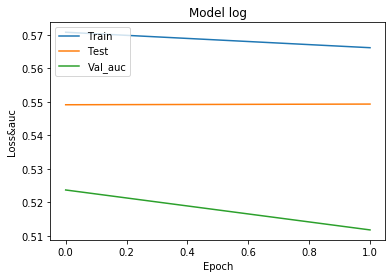

In [22]:
show_log(my_log)

In [26]:
from keras.utils.vis_utils import plot_model
#打印模型图到本地
plot_model(gru_model, to_file='sia_gru_with_exfeature_model.png',show_shapes=True,show_layer_names=True)

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [ ]:
#检测Qauc的程序，思路：把query_id相同的部分集群，然后计算其roc_auc_score，然后取所有的平均值
#输入result（一位数组），真实表文件（包括两个id和正确的标签），将输出qauc值
from sklearn.metrics import roc_auc_score
def metric_auc(predict,true):
    start_time = time.time()

    '''
    true:      DataFrame , ['query_id','query_title_id','label']
    predict:   np.array , [0.79,0.03,0.56,...]
    '''
    true = pd.concat([true.reset_index(drop=True),pd.DataFrame(predict)],axis=1)
    true.columns = ['query_id','query_title_id','label','predict']
    auc_score = []
    count = 0
    for i in tqdm(true.groupby('query_id'),mininterval=1.0):
        a = i[1]
        x = np.array(a['label'])
        y = np.array(a['predict'])
        try:
            auc_score.append(roc_auc_score(x,y))
        except:
            auc_score.append(0.5)  
            count+=1
    print(count)
    qauc = np.mean(auc_score)
    if qauc<0.5:
        qauc=1-qauc
    return qauc

In [ ]:
import time
start = time.time()
pred = gru_model.predict([train_query[-2000:],train_title[-2000:]])
print('using time'+str(time.time()-start))

In [ ]:
pred1=[]
lb1=[]
print(type(label))
for i in range(len(pred)):
    pred1.append(pred[i][0])
    #lb1.append(label[i][0])
pred1=np.array(pred1)
lb1=np.array(label)
print(pred1)

In [ ]:
import pandas as pd
true = pd.read_csv('valid.csv',header=None)
print(true[:10])
metric_auc(pred1,true)

In [ ]:
print(roc_auc_score(label[-2000:],pred1))